In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Users/krzysztofmakiel/opt/anaconda3/envs/blog/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
#https://www.envirosolutions.pl/otwarte-dane.html

gdf_admin=gpd.read_file('admins/admin_gen.shp')
gdf_roads_main=gpd.read_file('roads/roads_main_gen.shp')
gdf_rivers_main=gpd.read_file('rivers/rivers_main_gen.shp')

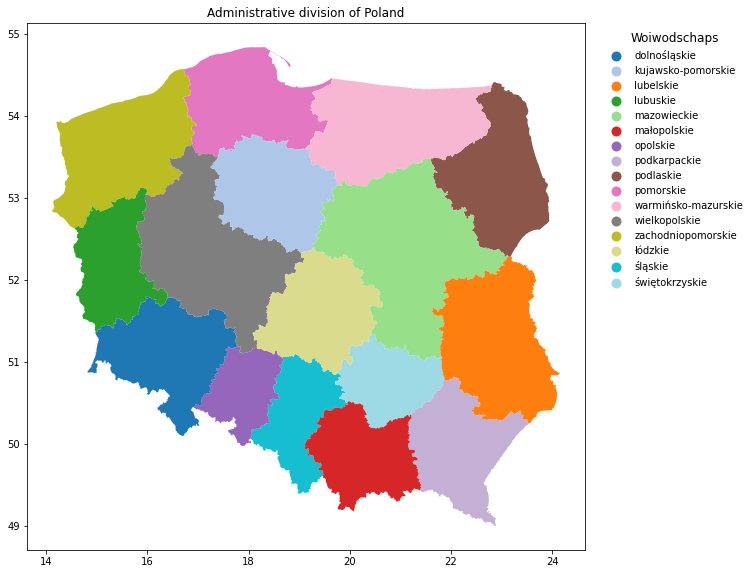

In [4]:
fig, ax = plt.subplots(1, 1,figsize=(10,20))

plt.title('Administrative division of Poland')
gdf_admin.plot(column='JPT_NAZWA_',
         ax=ax,
         legend=True,
         cmap='tab20',
         legend_kwds={'bbox_to_anchor':(1.3,1),
                      'title': 'Woiwodschaps',
                      'title_fontsize':12,
                      'frameon': False}
        );

In [5]:
m=gdf_admin.explore(column='JPT_NAZWA_',tooltip=False)

m

In [6]:
gdf_roads_main[gdf_roads_main.fclass=='motorway'].explore(m=m)

In [7]:
gdf_admin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
gdf_admin.estimate_utm_crs(datum_name='WGS 84')

<Projected CRS: EPSG:32634>
Name: WGS 84 / UTM zone 34N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, northern hemisphere between equator and 84°N, onshore and offshore. Albania. Belarus. Bosnia and Herzegovina. Bulgaria. Central African Republic. Chad. Croatia. Democratic Republic of the Congo (Zaire). Estonia. Finland. Greece. Hungary. Italy. Kosovo. Latvia. Libya. Lithuania. Montenegro. North Macedonia. Norway, including Svalbard and Bjornoys. Poland. Romania. Russian Federation. Serbia. Slovakia. Sudan. Sweden. Ukraine.
- bounds: (18.0, 0.0, 24.0, 84.0)
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
gdf_admin = gdf_admin.to_crs(32634)
gdf_roads_main = gdf_roads_main.to_crs(32634)
gdf_rivers_main = gdf_rivers_main.to_crs(32634)

In [ ]:
#gpd.GeoDataFrame(gdf_admin, geometry=gdf_admin.simplify(100,preserve_topology=True)).to_crs(4326).to_file('admins/admin_gen.shp',encoding='UTF-8')
#gpd.GeoDataFrame(gdf_roads_main, geometry=gdf_roads_main.simplify(10,preserve_topology=True)).to_crs(4326).to_file('roads/roads_main_gen.shp',encoding='UTF-8')
#gpd.GeoDataFrame(gdf_rivers_main, geometry=gdf_rivers_main.simplify(10,preserve_topology=True)).to_crs(4326).to_file('rivers/rivers_main_gen.shp',encoding='UTF-8')

In [10]:
gdf_admin.crs.name

'WGS 84 / UTM zone 34N'

In [11]:
def get_road_stats_per_admin(roads,admin):
    roads_admins=roads.sjoin(admin, how='left') 
    roads_admins['length']=roads_admins.geometry.length/1000
    return roads_admins.groupby('JPT_NAZWA_')['length'].sum()

In [12]:
get_road_stats_per_admin(gdf_roads_main,gdf_admin)

JPT_NAZWA_
dolnośląskie           4517.698455
kujawsko-pomorskie     3737.275930
lubelskie              3853.579712
lubuskie               2851.770112
mazowieckie            6743.371905
małopolskie            3211.618749
opolskie               2121.366627
podkarpackie           3228.039657
podlaskie              2728.736926
pomorskie              3627.990137
warmińsko-mazurskie    3314.643013
wielkopolskie          5597.587353
zachodniopomorskie     3675.951036
łódzkie                3574.281294
śląskie                3812.992296
świętokrzyskie         2069.404417
Name: length, dtype: float64

In [13]:
def get_bridges(roads, rivers):
    bridge_loc=roads.unary_union.intersection(rivers.unary_union)
    bridge_buff=gpd.GeoDataFrame(geometry=[p.buffer(10) for p in bridge_loc],crs=32634)
    return roads.clip(mask=bridge_buff, keep_geom_type=False).to_crs(4326)

In [14]:
gdf_bridge=get_bridges(gdf_roads_main, gdf_rivers_main)

In [15]:
gdf_bridge.explore(style_kwds={"color":"red"})

In [16]:
gdf_bridge.to_file('bridges/bridges.shp')